# Part 2: Pneumonia Prediction

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from os import listdir
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import transforms
from captum.attr import IntegratedGradients

### Q3 Integrated Gradients (5 Pts)

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return torch.sigmoid(x)

In [5]:
model = CNN()

# Load saved model
model.load_state_dict(torch.load("part2_cnn_weights/randomized_CNN_weights.pth", weights_only=True))
model.eval()

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [6]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Resize the image
    img = cv2.resize(img, (1000, 1000))

    # Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Histogram Equalization
    img = cv2.equalizeHist(img)

    # Gaussian Blur (5x5 kernel)
    final_img = cv2.GaussianBlur(img, (5, 5), 0)
    
    return final_img

In [7]:
# Testing label of a single image

input_img = preprocess_image("data_part2/train/PNEUMONIA/person1228_virus_2079.jpeg")
transform = transforms.ToTensor()
input_img = transform(input_img).unsqueeze(0)

# Note that 0 = NORMAL, 1 = PNEUMONIA
output = model(input_img)
predicted = (output > 0.5).float()
print("Predicted:", predicted.item())

Predicted: 1.0


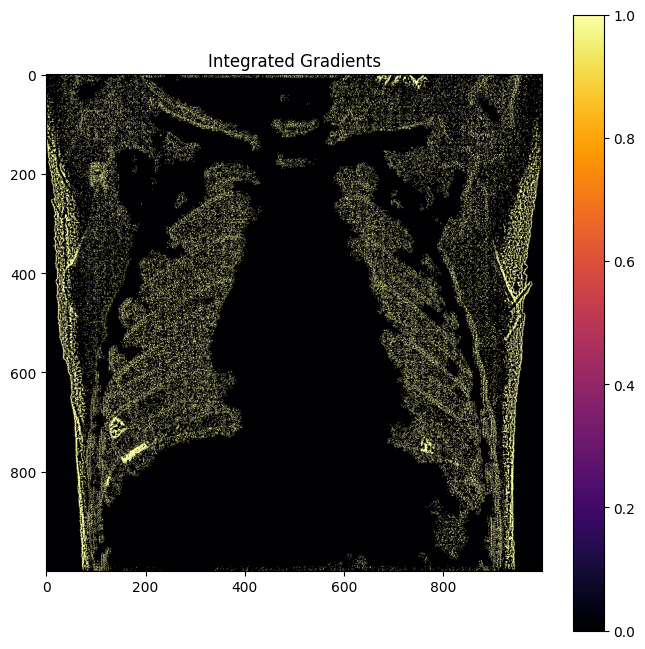

In [8]:
# Printing integrated gradients for a single image (for testing purposes)

input_img = Image.open("data_part2_processed/train/NORMAL/IM-0117-0001.jpeg")
transform = transforms.ToTensor()
input_img = transform(input_img).unsqueeze(0)


#baseline = torch.rand_like(input_img)
blurred = TF.gaussian_blur(input_img.squeeze(0), kernel_size=9)
baseline = blurred.unsqueeze(0)
integrated_gradients = IntegratedGradients(model)

attributions, delta = integrated_gradients.attribute(
    input_img,
    baselines=baseline,
    target=0,
    return_convergence_delta=True
)

attr = attributions.squeeze().detach().cpu().numpy()
attr_norm = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)

plt.figure(figsize=(8, 8))
threshold = np.percentile(attr_norm, 90)
plt.imshow(attr_norm > threshold, cmap="inferno")
plt.colorbar()
plt.title("Integrated Gradients")
plt.show()

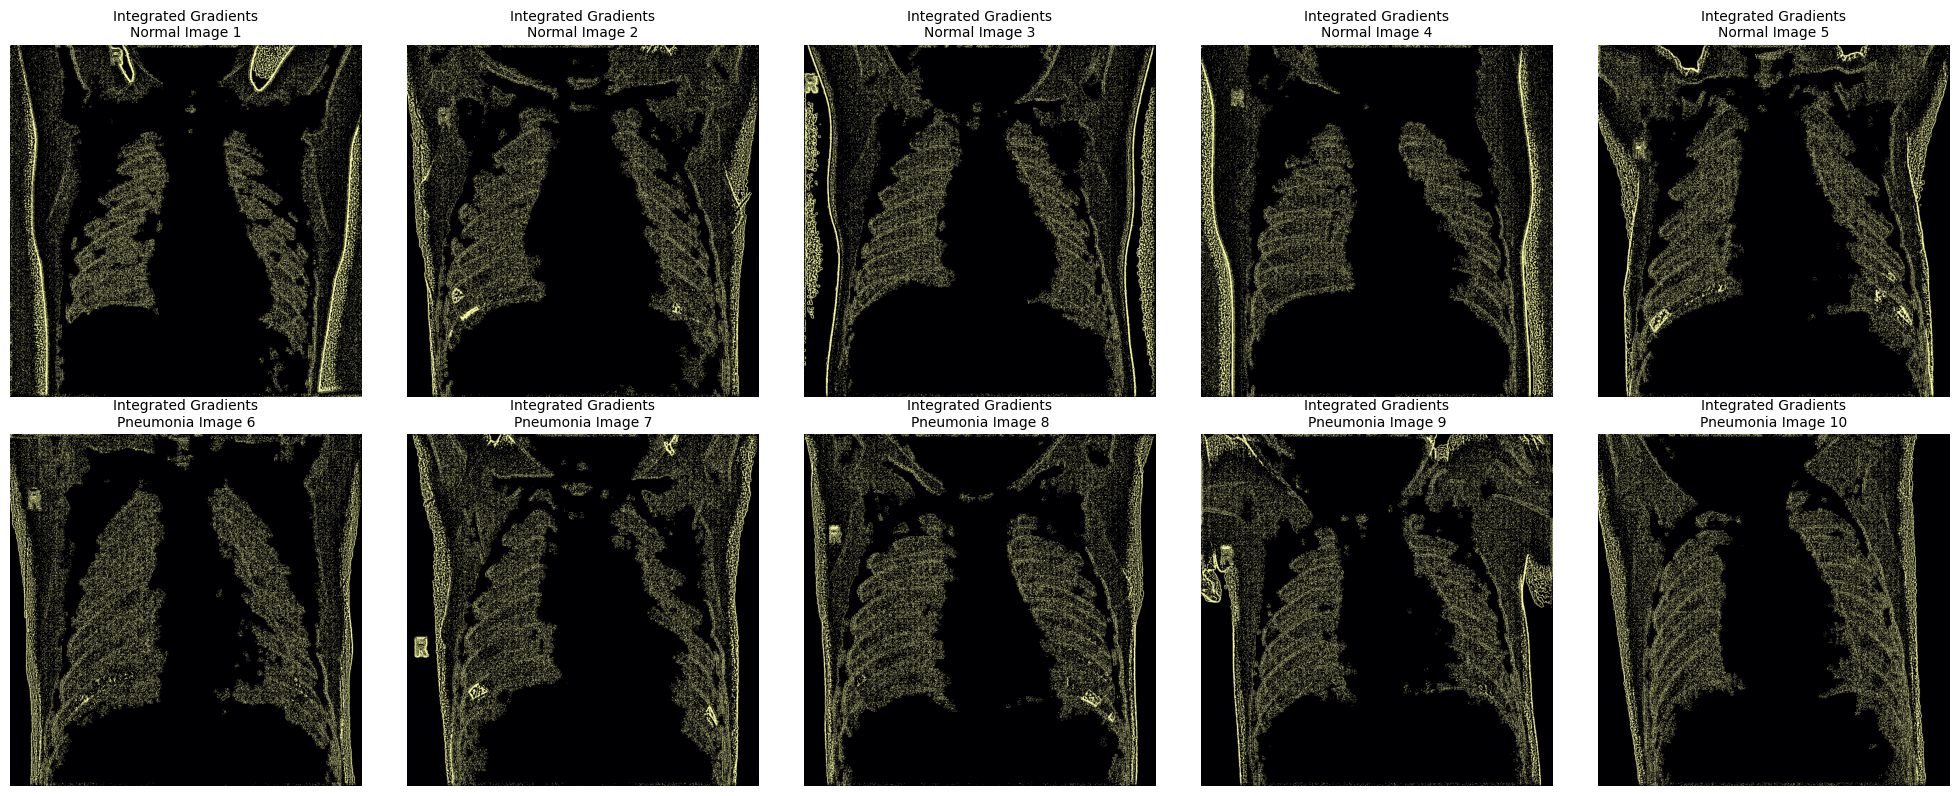

In [24]:
# Plotting the integrated gradients for 5 normal and 5 pneumonia images

data_dir = "data_part2_processed/train"
normal_dir = os.path.join(data_dir, "NORMAL")
pneumonia_dir = os.path.join(data_dir, "PNEUMONIA")

# Loading 5 normal and 5 pneumonia image filenames
normal_images = sorted([f for f in os.listdir(normal_dir)])

pneumonia_images = sorted([f for f in os.listdir(pneumonia_dir)])

all_image_paths = [os.path.join(normal_dir, f) for f in normal_images] + \
                  [os.path.join(pneumonia_dir, f) for f in pneumonia_images]

labels = ["Normal"] * 5 + ["Pneumonia"] * 5

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, (image_path, label) in enumerate(zip(all_image_paths, labels)):
    input_img = Image.open(image_path)
    transform = transforms.ToTensor()
    input_img = transform(input_img).unsqueeze(0)

    # Blur image as a baseline
    blurred = TF.gaussian_blur(input_img.squeeze(0), kernel_size=9)
    baseline = blurred.unsqueeze(0)

    # Random baseline 
    #baseline = torch.rand_like(input_img)

    # Zero baseline
    #baseline = torch.zeros_like(input_img)

    integrated_gradients = IntegratedGradients(model)
    attributions, delta = integrated_gradients.attribute(
        input_img,
        baselines=baseline,
        target=0,
        return_convergence_delta=True
    )

    attr = attributions.squeeze().detach().cpu().numpy()

    attr_norm = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
    threshold = np.percentile(attr_norm, 90)

    axes[idx].imshow(attr_norm > threshold, cmap="inferno")
    axes[idx].set_title(f"Integrated Gradients\n{label} Image {idx+1}", fontsize=10)
    axes[idx].axis("off")

plt.tight_layout()
# --- Save before showing ---
fig.savefig(
    "random_baseline.png",   # your filename
    dpi=300,               # high resolution
    bbox_inches="tight"    # trims extra whitespace
)
plt.show()


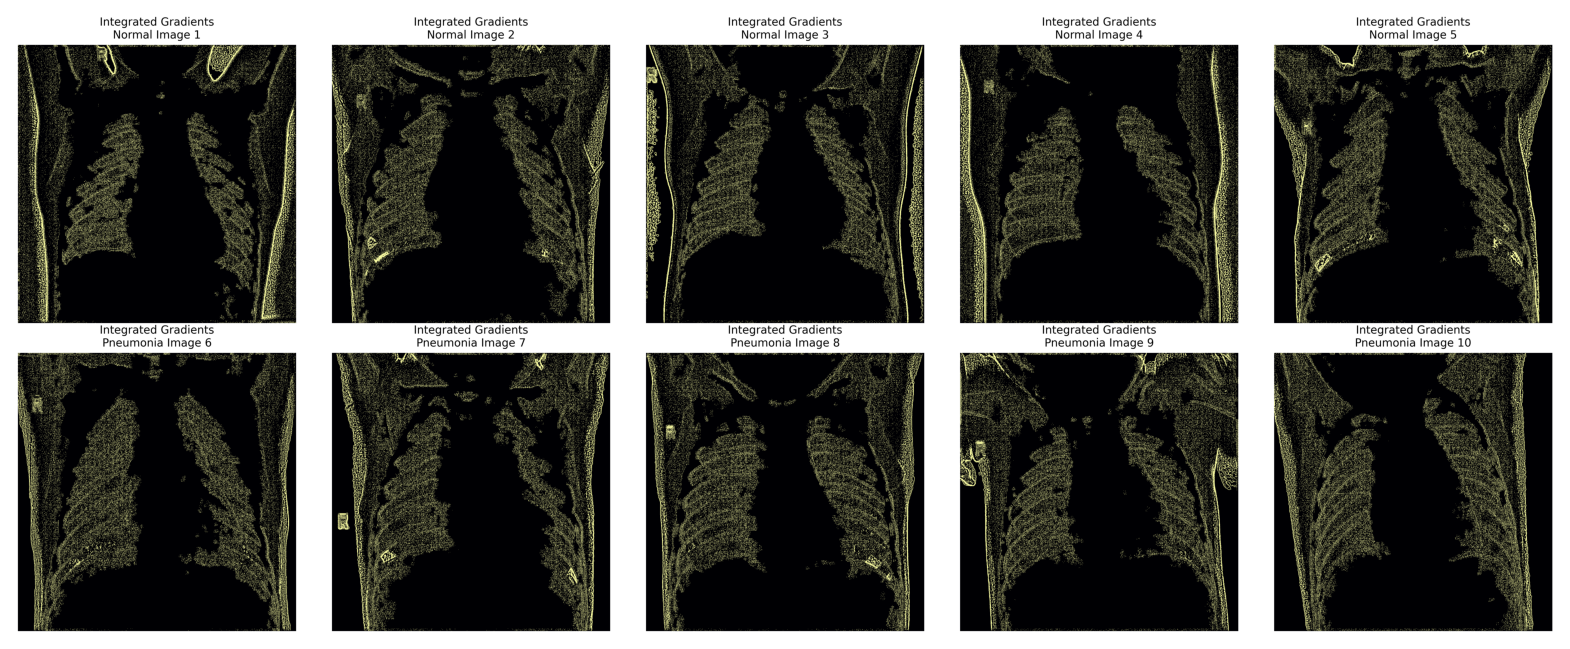

In [25]:
# blurred baseline
img = Image.open("blurred_baseline.png")
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis("off")
plt.show()

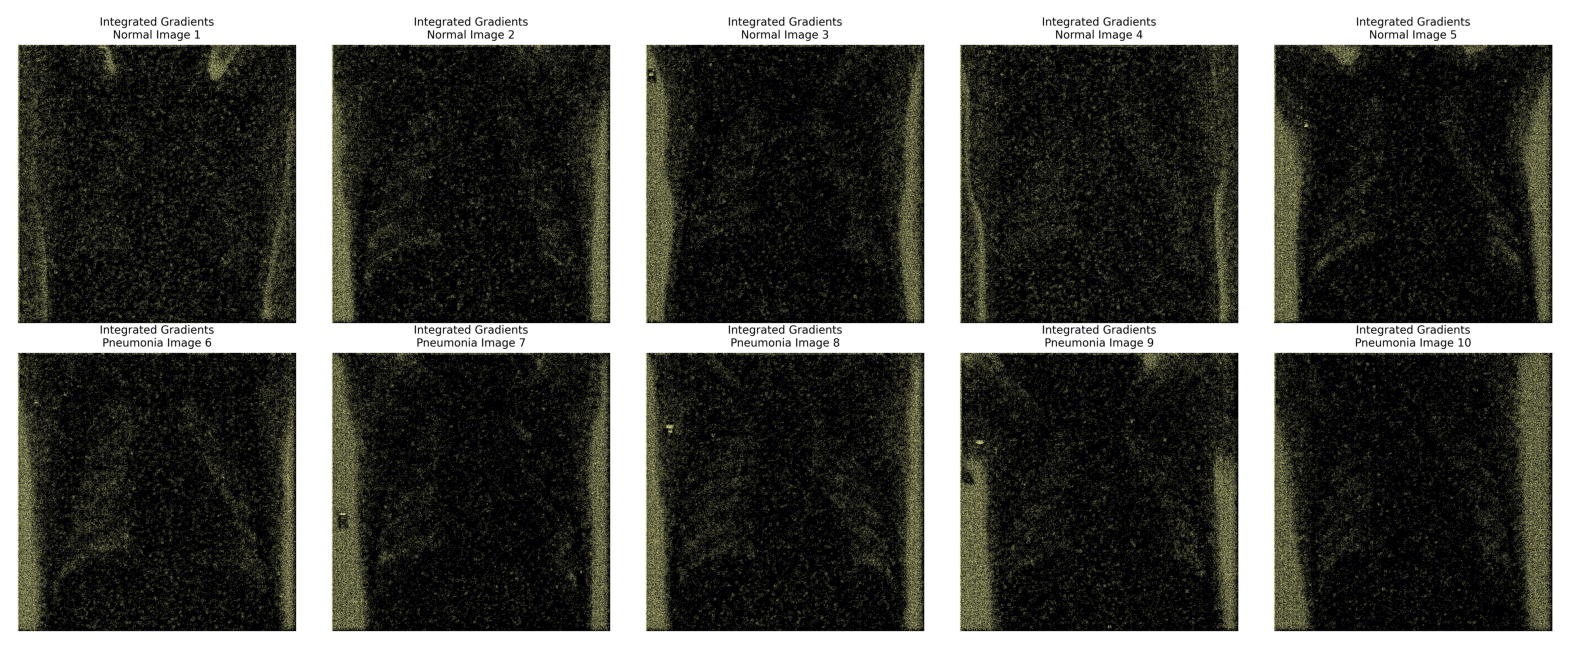

In [23]:
# Ranodm baseline
img = Image.open("random_baseline.png")
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis("off")
plt.show()

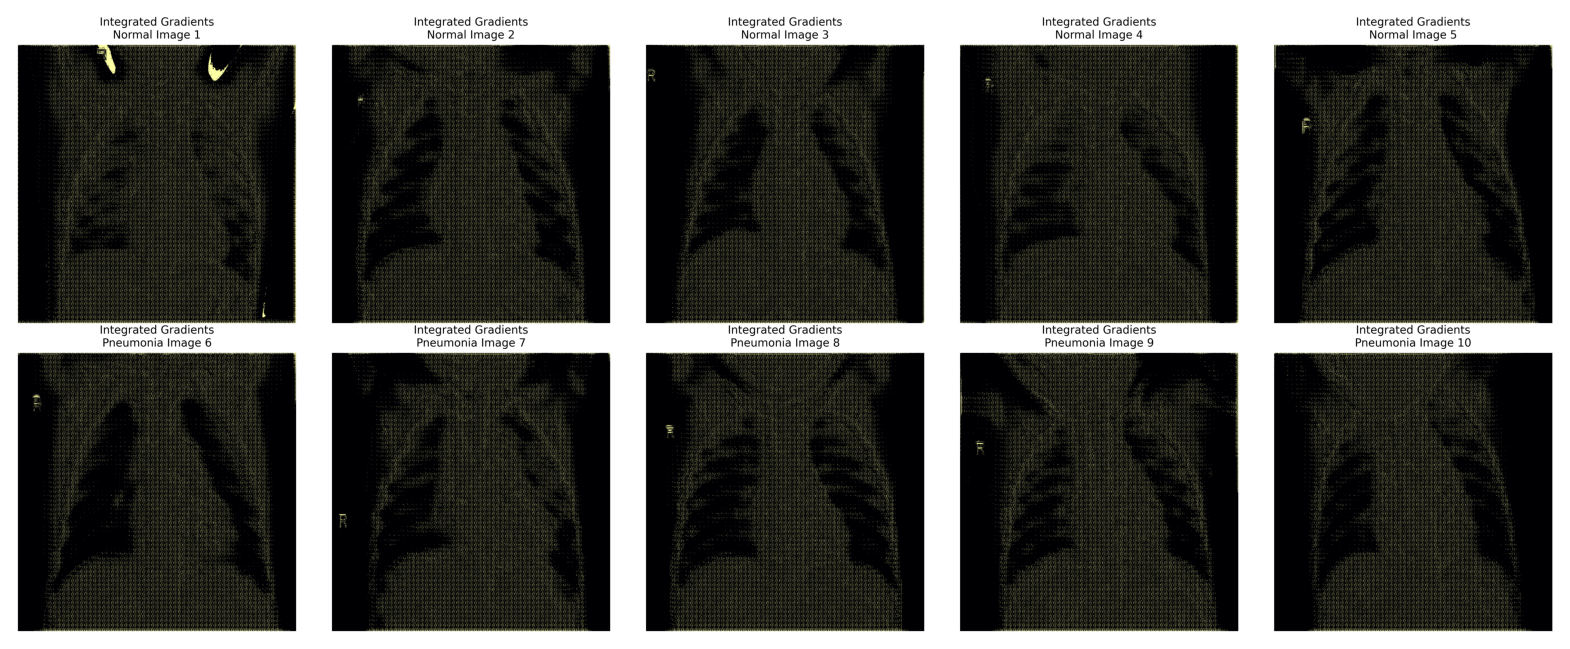

In [21]:
# Zero baseline
img = Image.open("zero_baseline.png")
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis("off")
plt.show()